# Convolutional Generative Adversarial Network

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
from skimage.io import imsave
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.4 * 2, 4.8 * 2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Load data

In [2]:
data_path = os.path.expanduser('~/Datasets/mnist')
mnist = input_data.read_data_sets(data_path, one_hot=True)

Extracting /Users/v-shmyhlo/Datasets/mnist/train-images-idx3-ubyte.gz
Extracting /Users/v-shmyhlo/Datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/v-shmyhlo/Datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/v-shmyhlo/Datasets/mnist/t10k-labels-idx1-ubyte.gz


### Helpers

In [3]:
def generator(z_prior):
  with tf.variable_scope('generator'):
    net = z_prior
    net = tf.nn.leaky_relu(tf.layers.conv2d_transpose(net, 16, [5, 5]))
    net = tf.nn.dropout(net, keep_prob)
    net = tf.nn.leaky_relu(tf.layers.conv2d_transpose(net, 8, [5, 5]))
    net = tf.nn.dropout(net, keep_prob)
    net = tf.nn.tanh(tf.layers.conv2d_transpose(net, 1, [5, 5]))
    
    x_generated = net
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
    
  return x_generated, params

def discriminator(x_data, x_generated):
  with tf.variable_scope('discriminator'):
    net = tf.concat([x_data, x_generated], 0)
    net = tf.nn.leaky_relu(tf.layers.conv2d(net, 8, [5, 5]))
    net = tf.nn.dropout(net, keep_prob)
    net = tf.nn.leaky_relu(tf.layers.conv2d(net, 16, [5, 5]))
    net = tf.nn.dropout(net, keep_prob)
    net = tf.nn.sigmoid(tf.layers.conv2d(net, 1, [5, 5]))
  
    y_data = tf.slice(net, [0, 0, 0, 0], [batch_size, -1, -1, -1], name=None)
    y_generated = tf.slice(net, [batch_size, 0, 0, 0], [-1, -1, -1, -1], name=None)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    
  return y_data, y_generated, params

def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):
  batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], img_height, img_width)) + 0.5
  img_h, img_w = batch_res.shape[1], batch_res.shape[2]
  grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)
  grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)
  img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
  
  for i, res in enumerate(batch_res):
    if i >= grid_size[0] * grid_size[1]:
      break
    img = (res) * 255
    img = img.astype(np.uint8)
    row = (i // grid_size[0]) * (img_h + grid_pad)
    col = (i % grid_size[1]) * (img_w + grid_pad)
    img_grid[row:row + img_h, col:col + img_w] = img
    
  imsave(fname, img_grid)

### Build a graph

In [4]:
img_height = 28
img_width = 28
h1_size = 150
h2_size = 300
batch_size = 256
z_shape = [batch_size, 16, 16, 1]

tf.reset_default_graph()

x_data = tf.placeholder(tf.float32, [batch_size, img_height, img_width, 1], name='x_data')
z_prior = tf.placeholder(tf.float32, z_shape, name='z_prior')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
global_step = tf.Variable(0, name='global_step', trainable=False)

x_generated, g_params = generator(z_prior)
y_data, y_generated, d_params = discriminator(x_data, x_generated)

d_loss = -tf.reduce_mean(tf.log(y_data) + tf.log(1 - y_generated))
g_loss = -tf.reduce_mean(tf.log(y_generated))

with tf.name_scope('summaries'):
  tf.summary.scalar('d_loss', d_loss)
  tf.summary.scalar('g_loss', g_loss)
  tf.summary.scalar('loss', d_loss + g_loss)
  tf.summary.scalar('learning_rate', learning_rate)

d_train = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_params)
g_train = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_params)

merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

6
6
12


### Train

In [5]:
restore = True
output_path = os.path.join('output', 'dcgan')
log_path = os.path.join('tf_log', 'dcgan')
model_name = os.path.join(log_path, 'model')
n_steps = 1000
log_interval = 100
save_interval = 100
d_steps = 1
g_steps = 1
kp = 0.75
lr = 1e-5

def normalize_image(x):
  return (x * 2 - 1).reshape((-1, 28, 28, 1))

with tf.Session() as sess:
  train_writer = tf.summary.FileWriter(os.path.join(log_path, 'train'), sess.graph)
  
  if restore:
    chkpt_fname = tf.train.latest_checkpoint(log_path)
    saver.restore(sess, chkpt_fname)
  else:
    sess.run(init)
    if os.path.exists(output_path):
      shutil.rmtree(output_path)
    os.mkdir(output_path)

  z_sample_val = np.random.normal(0, 1, size=z_shape).astype(np.float32)
  
  for i in range(sess.run(global_step), n_steps):
    x_train = normalize_image(mnist.train.next_batch(batch_size)[0])
    z_value = np.random.normal(0, 1, size=z_shape).astype(np.float32)
    
    for k in range(d_steps):
      sess.run(d_train,
               feed_dict={x_data: x_train, z_prior: z_value, keep_prob: kp, learning_rate: lr})

    for k in range(g_steps):
      sess.run(g_train,
               feed_dict={x_data: x_train, z_prior: z_value, keep_prob: kp, learning_rate: lr})
        
    if i % log_interval == 0:
      g_l, d_l, summary = sess.run([g_loss, d_loss, merged], 
                          feed_dict={x_data: normalize_image(mnist.validation.images[:batch_size]), 
                                     z_prior: z_sample_val, 
                                     keep_prob: 1,
                                     learning_rate: lr})
      print('step: %d/%d, loss: %f (g_loss: %f, d_loss: %f)' % 
            (i, n_steps, g_l + d_l, g_l, d_l))

      train_writer.add_summary(summary, i)
      train_writer.flush()
    
    if i % save_interval == 0:
      x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_sample_val, keep_prob: 1})
      show_result(x_gen_val, os.path.join(output_path, 'sample%s.jpg' % i))

      z_random_sample_val = np.random.normal(0, 1, size=z_shape).astype(np.float32)
      x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_random_sample_val, keep_prob: 1})
      show_result(x_gen_val, os.path.join(output_path, 'random_sample%s.jpg' % i))

      sess.run(tf.assign(global_step, i + 1))
      save_path = saver.save(sess, model_name, global_step=global_step)
      print('model saved: %s' % save_path)

INFO:tensorflow:Restoring parameters from tf_log/dcgan/model-91
step: 100/1000, loss: 1.997677 (g_loss: 0.682319, d_loss: 1.315358)
model saved: tf_log/dcgan/model-101
step: 200/1000, loss: 1.949665 (g_loss: 0.646448, d_loss: 1.303218)
model saved: tf_log/dcgan/model-201
step: 300/1000, loss: 1.921274 (g_loss: 0.604951, d_loss: 1.316323)
model saved: tf_log/dcgan/model-301
step: 400/1000, loss: 1.912418 (g_loss: 0.582189, d_loss: 1.330229)
model saved: tf_log/dcgan/model-401
step: 500/1000, loss: 1.912676 (g_loss: 0.588214, d_loss: 1.324462)
model saved: tf_log/dcgan/model-501
step: 600/1000, loss: 1.914279 (g_loss: 0.617041, d_loss: 1.297238)
model saved: tf_log/dcgan/model-601
step: 700/1000, loss: 1.916632 (g_loss: 0.661694, d_loss: 1.254938)
model saved: tf_log/dcgan/model-701
step: 800/1000, loss: 1.920516 (g_loss: 0.715951, d_loss: 1.204565)
model saved: tf_log/dcgan/model-801
step: 900/1000, loss: 1.917283 (g_loss: 0.752853, d_loss: 1.164430)
model saved: tf_log/dcgan/model-901


### Visualize

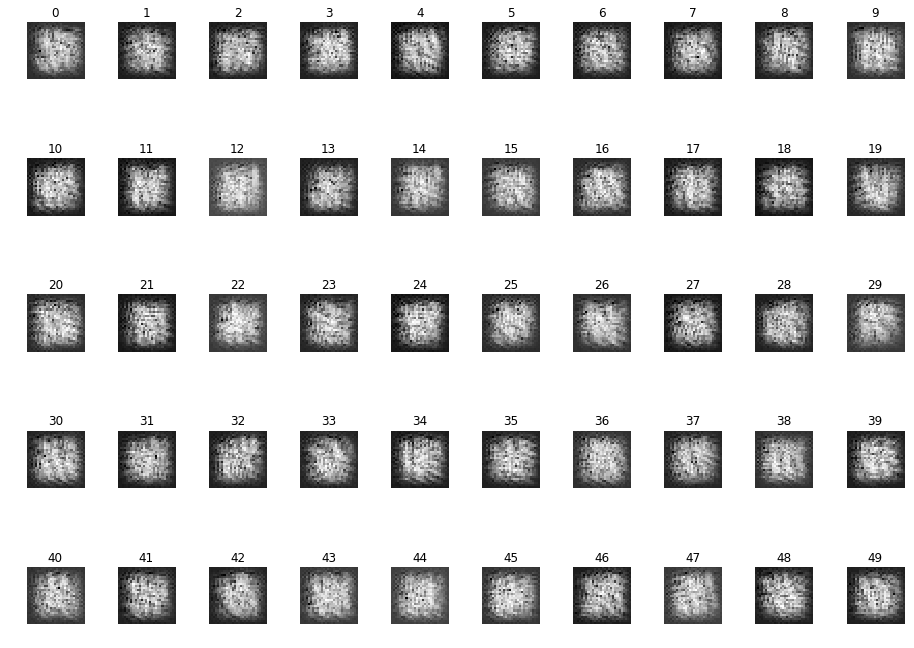

In [6]:
n_rows = 5
n_columns = 10
n_samples = n_rows * n_columns
x = x_gen_val[:n_samples].reshape(-1, img_height, img_width)
fig = plt.figure()
cmap = 'binary'

for r in range(n_rows):
  for c in range(n_columns):
    n = r * n_columns + c
    a = fig.add_subplot(n_rows, n_columns, n + 1)
    a.set_title(n)
    implot = plt.imshow(x[n, :, :])
    implot.set_cmap(cmap)
    plt.axis('off')

fig.tight_layout()